# 1. Install Dependencies & Setup

- GPU support on native-Windows is only available for 2.10 or earlier versions, starting in TF 2.11, CUDA build is not supported for Windows. For using TensorFlow GPU on Windows, you will need to build/install TensorFlow in WSL2 or use tensorflow-cpu with TensorFlow-DirectML-Plugin

In [1]:
# import libraries
import tensorflow as tf
import os

In [2]:
# Restrict tensorflow from using all the memory on the GPU
gpus = tf.config.experimental.list_physical_devices('GPU')

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
# Check if the GPU is available
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 2. Remove corrupted files

- We are using an extension called "Download All Images" (Edge/Chrome) and some of the files it downloads from Google Images may not be images at all, so we need to remove them.

In [4]:
# import libraries

import cv2
import imghdr

In [5]:
# create variable to store the path to the dataset
data_dir = 'data'

# create a list to store the image extensions
img_extensions = ['jpg', 'png', 'jpeg', 'bmp']

# main loop to iterate through the folders and filter out the images
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)

        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)

            if tip not in img_extensions:
                print('Image not in correct format: ', image_path)
                os.remove(image_path)
        
        except Exception as e:
            print('Image not readable: ', image_path)

# 3. Load Data

In [6]:
import numpy as np
import matplotlib.pyplot as plt

In [7]:
# Load the documentation and arguments
# tf.keras.utils.image_dataset_from_directory??

In [8]:
# The keras utils helps to resize, preprocess and load the images into the model
data = tf.keras.utils.image_dataset_from_directory('data')

Found 304 files belonging to 2 classes.


In [9]:
# Create a data iterator
data_iterator = data.as_numpy_iterator()
data_iterator

In [10]:
# Create the batch
batch = next(data_iterator)

# Numpy array representation of the batch
print(batch[0].shape)

# Print the labels
print(batch[1])

(32, 256, 256, 3)
[0 1 0 1 0 1 0 0 0 1 1 0 1 0 1 0 0 0 1 1 0 0 0 1 0 0 1 0 1 0 0 0]


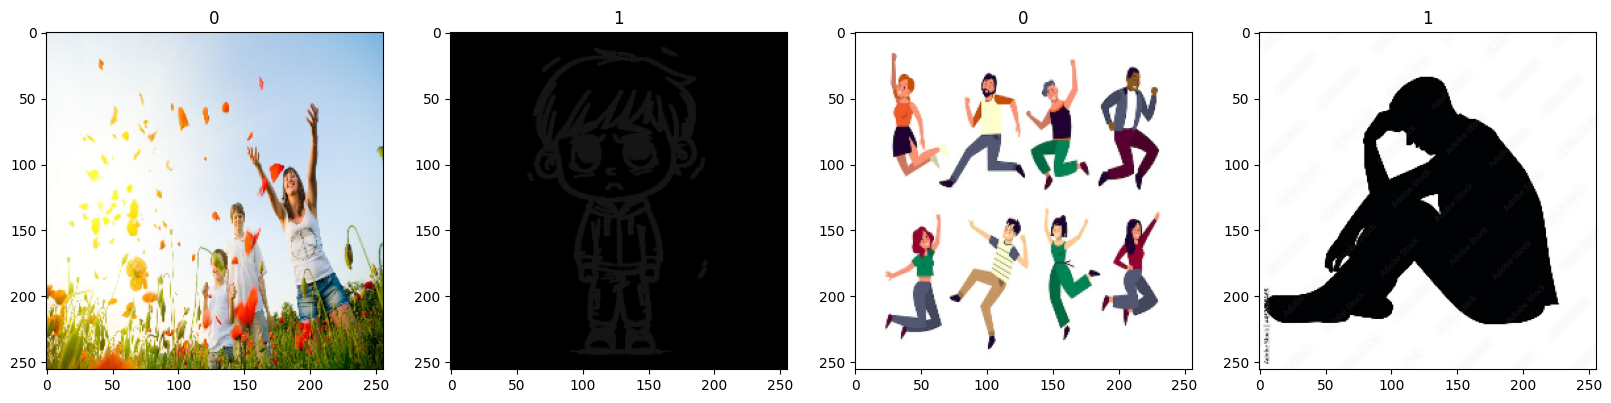

In [11]:
# To determine if 1 is happy or sad
fig, ax = plt.subplots(ncols = 4, figsize = (20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype('int'))
    ax[idx].title.set_text(batch[1][idx])

# 4. Preprocess Data

## 4.1 Scale Data

- Reduce the 0, 255 to 0, 1 for faster training, and better performance.

In [12]:
# Create a function to preprocess the images, image scale down to 0-1, label no change
data_scaled = data.map(lambda image, label : (image/255, label))

# Declare the iterator
scaled_iterator = data_scaled.as_numpy_iterator()

# Create the batch
batch = scaled_iterator.next()

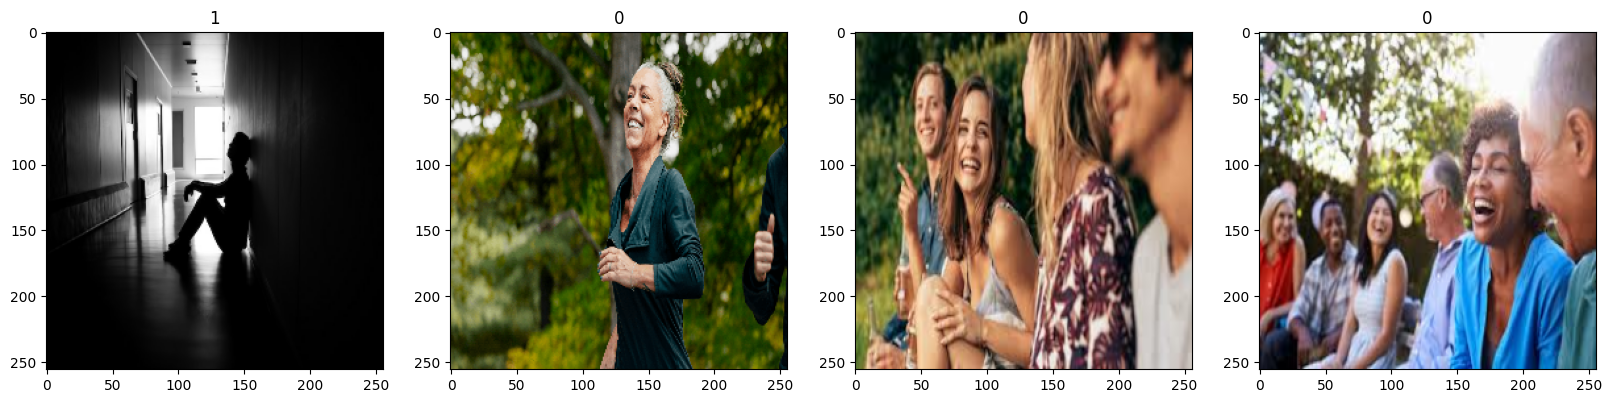

In [13]:
# Test the batch
fig, ax = plt.subplots(ncols = 4, figsize = (20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype('float'))
    ax[idx].title.set_text(batch[1][idx])

## 4.2 Split Data

In [14]:
# Split the data into train and test

# Create the train data - this is what the model will see and learn from
train_size = int(len(data_scaled) * 0.6)

# Create the test data - this is what the model will not see until it is ready to be tested
test_size = int(len(data_scaled) * 0.2) + 1

# Create the validation data - this is what the model will use to test itself while training and learn from
validation_size = int(len(data_scaled) * 0.1) + 1

In [15]:
# Create the train data
train_data = data_scaled.take(train_size)

# Create the test data
test_data = data.skip(train_size).take(test_size)

# Create the validation data
validation_data = data.skip(train_size + test_size).take(validation_size)

In [16]:
# Check the length of the data
print("The length of the train data is: ", len(train_data))
print("The length of the test data is: ", len(test_data))
print("The length of the validation data is: ", len(validation_data))

The length of the train data is:  6
The length of the test data is:  3
The length of the validation data is:  1


# 5. Deep Model

## 5.1 Create Model

In [17]:
# Import Sequential model for basic input to output model
from tensorflow.keras.models import Sequential

# Import the layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [18]:
# Create the model
model = Sequential()

# Add the layers (# of filters, size of the filter, stride, activation function)
# The activation function introduces non-linearity into the model for the model to learn
# Relu : Rectified Linear Unit sets all negative values to 0 and keeps all positive values
# Sigmoid: Sigmoid function squashes the values between 0 and 1

model.add(Conv2D(16, (3, 3), 1, activation = 'relu', input_shape = (256, 256, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3, 3), 1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3, 3), 1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation = 'relu'))

# Maps the output to 0 or 1, representing happy or sad
model.add(Dense(1, activation = 'sigmoid'))

In [19]:
# Compile the model
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [20]:
# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

## 5.2 Train Model

In [21]:
# Create log directory
log_dir = 'logs'

# Create a tensorboard callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq = 1)

In [22]:
# Fit the model
fitted_model = model.fit(train_data, epochs = 20, validation_data = validation_data, callbacks = [tensorboard_callback])

Epoch 1/20


6/6 [==============================] - 4s 223ms/step - loss: 1.3495 - accuracy: 0.4896 - val_loss: 97.5989 - val_accuracy: 0.6250
Epoch 2/20
6/6 [==============================] - 2s 207ms/step - loss: 0.6874 - accuracy: 0.6042 - val_loss: 11.2403 - val_accuracy: 0.7500
Epoch 3/20
6/6 [==============================] - 2s 205ms/step - loss: 0.5892 - accuracy: 0.7292 - val_loss: 39.1780 - val_accuracy: 0.5625
Epoch 4/20
6/6 [==============================] - 2s 198ms/step - loss: 0.5512 - accuracy: 0.6927 - val_loss: 24.0285 - val_accuracy: 0.8125
Epoch 5/20
6/6 [==============================] - 2s 206ms/step - loss: 0.4835 - accuracy: 0.7917 - val_loss: 18.8157 - val_accuracy: 0.8125
Epoch 6/20
6/6 [==============================] - 2s 204ms/step - loss: 0.4183 - accuracy: 0.8438 - val_loss: 19.4280 - val_accuracy: 0.8125
Epoch 7/20
6/6 [==============================] - 2s 202ms/step - loss: 0.3727 - accuracy: 0.8125 - val_loss: 0.0099 - val_accuracy: 1.0000
Epoch 8/20
6/6 [=========

In [23]:
fitted_model.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

## Plot The Model's Accuracy And Loss Over Time

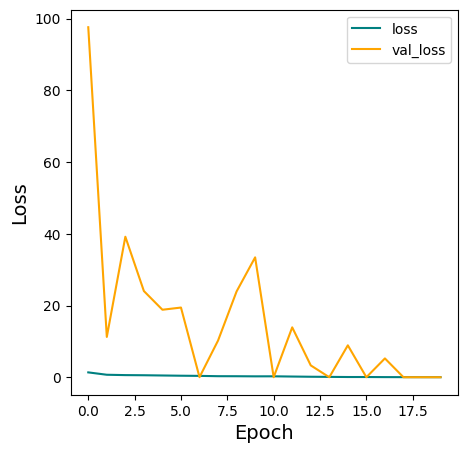

In [24]:
# Plot the loss
figure = plt.figure(figsize = (5, 5))

# plot loss during training
plt.plot(fitted_model.history['loss'], color="teal", label="loss")
plt.plot(fitted_model.history['val_loss'], color="orange", label="val_loss")
fig.suptitle('Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc='upper right')
plt.show()

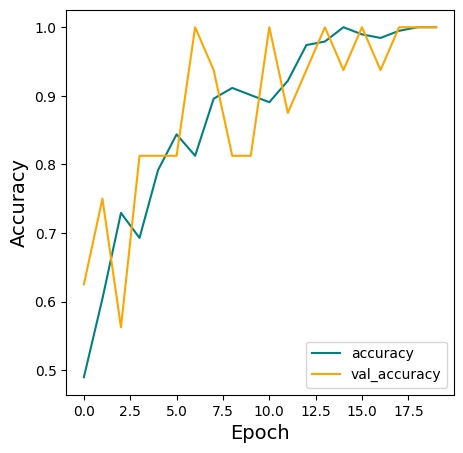

In [25]:
# Plot the accuracy
figure = plt.figure(figsize = (5, 5))

# plot accuracy during training
plt.plot(fitted_model.history['accuracy'], color="teal", label="accuracy")
plt.plot(fitted_model.history['val_accuracy'], color="orange", label="val_accuracy")
fig.suptitle('Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(loc='lower right')
plt.show()

# 6. Evaluate Model

## 6.1 Evaluation

In [26]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [27]:
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

In [29]:
for batch in test_data.as_numpy_iterator():
    X, y = batch
    y_pred = model.predict(X)

    precision.update_state(y, y_pred)
    recall.update_state(y, y_pred)
    accuracy.update_state(y, y_pred)

In [30]:
# Print the metrics

print("Precision: ", precision.result().numpy())
print("Recall: ", recall.result().numpy())
print("Accuracy: ", accuracy.result().numpy())

Precision:  1.0
Recall:  0.97727275
Accuracy:  0.9895833


## 6.2 Test Model

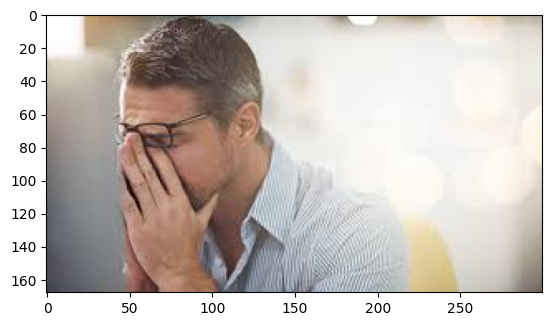

In [47]:
# Load unseen data

img = cv2.imread('data/unseen_data/sad-1.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [52]:
# Resize the image
resize_img = tf.image.resize(img, (256, 256))

# Predict the image
# The purpose of the np.expand_dims is to add a dimension to the image to make it 4 dimensional, as the model is expecting a batch of images
prediction = model.predict(np.expand_dims(resize_img/255, axis = 0))

# Print the prediction
if prediction > 0.5:
    print(f"The image is sad with a probability of {prediction[0][0]}")
else:
    print(f"The image is happy with a probability of {1 - prediction[0][0]}")

The image is sad with a probability of 0.8047887086868286


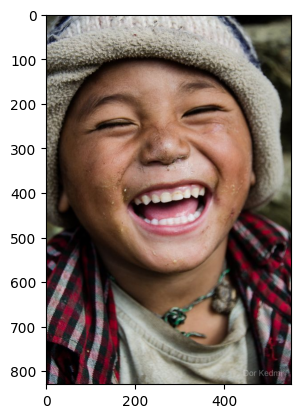

In [54]:
img = cv2.imread('data/unseen_data/happy-1.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [56]:
# Resize the image
resize_img = tf.image.resize(img, (256, 256))

# Predict the image
# The purpose of the np.expand_dims is to add a dimension to the image to make it 4 dimensional, as the model is expecting a batch of images
prediction = model.predict(np.expand_dims(resize_img/255, axis = 0))

# Print the prediction
if prediction > 0.5:
    print(f"The image is sad with a probability of {prediction[0][0]}")
else:
    print(f"The image is happy with a probability of {1 - prediction[0][0]}")

The image is happy with a probability of 0.8221730887889862


# 7. Save Model

## 7.1 Save Model

In [57]:
from tensorflow.keras.models import load_model

In [58]:
# Export the model to a file

model.save(os.path.join('models', 'moodpredictor.h5'))

In [59]:
# Test reload the model

new_model = load_model(os.path.join('models', 'moodpredictor.h5'))

In [60]:
# Resize the image
resize_img = tf.image.resize(img, (256, 256))

# Predict the image
# The purpose of the np.expand_dims is to add a dimension to the image to make it 4 dimensional, as the model is expecting a batch of images
prediction_new = new_model.predict(np.expand_dims(resize_img/255, axis = 0))

# Print the prediction
if prediction_new > 0.5:
    print(f"The image is sad with a probability of {prediction[0][0]}")
else:
    print(f"The image is happy with a probability of {1 - prediction[0][0]}")

The image is happy with a probability of 0.8221730887889862
